In [63]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time
from torchvision import transforms as T, models

import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image 
from sklearn.manifold import TSNE
from tqdm import tqdm
%matplotlib inline

In [68]:
%ls Archive/EuroSAT/ 

AnnualCrop/           Industrial/           River/
Forest/               Pasture/              SeaLake/
HerbaceousVegetation/ PermanentCrop/
Highway/              Residential/


In [70]:
data = []
folder = 'Archive/EuroSAT/'
fold=['AnnualCrop/','Industrial/','River/','Forest/','Pasture/','SeaLake/','HerbaceousVegetation/','PermanentCrop/','Highway/','Residential/']
for f in fold:
    for filename in tqdm((os.listdir(folder+f))):
        image = cv2.imread(os.path.join(folder+f,filename))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (45,45))
            image = image.flatten()
            data.append([image, folder+f+ filename])

100%|█████████████████████████████████████| 3000/3000 [00:00<00:00, 5815.76it/s]


In [72]:
features, images  = zip(*data)

In [73]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [74]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]


In [75]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=350, perplexity=30, angle=0.2, verbose=2).fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27000 samples in 0.005s...
[t-SNE] Computed neighbors for 27000 samples in 15.518s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27000
[t-SNE] Computed conditional probabilities for sample 2000 / 27000
[t-SNE] Computed conditional probabilities for sample 3000 / 27000
[t-SNE] Computed conditional probabilities for sample 4000 / 27000
[t-SNE] Computed conditional probabilities for sample 5000 / 27000
[t-SNE] Computed conditional probabilities for sample 6000 / 27000
[t-SNE] Computed conditional probabilities for sample 7000 / 27000
[t-SNE] Computed conditional probabilities for sample 8000 / 27000
[t-SNE] Computed conditional probabilities for sample 9000 / 27000
[t-SNE] Computed conditional probabilities for sample 10000 / 27000
[t-SNE] Computed conditional probabilities for sample 11000 / 27000
[t-SNE] Computed conditional probabilities for sample 12000 / 27000
[t-SNE] Computed conditional probabilities for sa

In [76]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

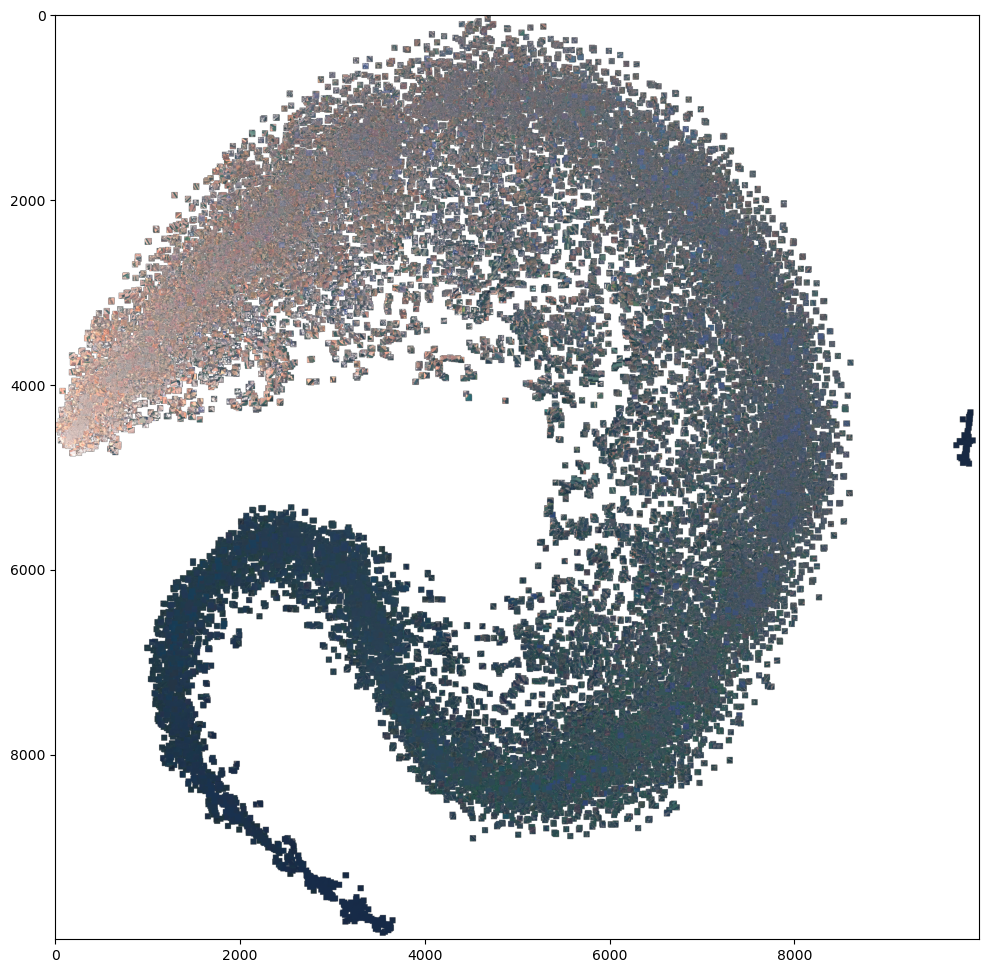

In [80]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 10000
height = 10000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [71]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.jpg"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [15]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['Archive/EuroSAT/Forest', 'Archive/EuroSAT/River', 'Archive/EuroSAT/Highway', 'Archive/EuroSAT/AnnualCrop', 'Archive/EuroSAT/SeaLake', 'Archive/EuroSAT/HerbaceousVegetation', 'Archive/EuroSAT/Industrial', 'Archive/EuroSAT/Residential', 'Archive/EuroSAT/PermanentCrop', 'Archive/EuroSAT/Pasture']
[['Archive/EuroSAT/Forest/Forest_864.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2917.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2903.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_870.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_680.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_858.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2095.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_2081.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1588.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_694.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1205.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_119.jpg', 'Forest'], ['Archive/EuroSAT/Forest/Forest_1563.jpg', 'Forest'], ['Arch

In [16]:
def plot_data_loader(data_loader, gridDims):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


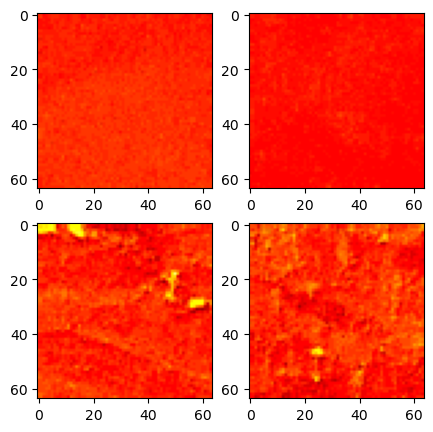

In [17]:
plot_data_loader(data_loader_test,[2,2])

In [18]:
 model = models.resnet18(pretrained=False)


/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [20]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [21]:
model.to(device)

num_epochs = 30
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0;
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/30], Step [100/540], Loss: 0.8225, Accuracy: 71.88%
Epoch [1/30], Step [200/540], Loss: 1.5445, Accuracy: 50.00%
Epoch [1/30], Step [300/540], Loss: 0.4791, Accuracy: 81.25%
Epoch [1/30], Step [400/540], Loss: 0.7887, Accuracy: 78.12%
Epoch [1/30], Step [500/540], Loss: 0.4337, Accuracy: 87.50%
Epoch [2/30], Step [100/540], Loss: 0.7544, Accuracy: 71.88%
Epoch [2/30], Step [200/540], Loss: 0.5583, Accuracy: 78.12%
Epoch [2/30], Step [300/540], Loss: 0.4013, Accuracy: 84.38%
Epoch [2/30], Step [400/540], Loss: 0.8996, Accuracy: 56.25%
Epoch [2/30], Step [500/540], Loss: 0.6378, Accuracy: 81.25%
Epoch [3/30], Step [100/540], Loss: 0.4187, Accuracy: 87.50%
Epoch [3/30], Step [200/540], Loss: 0.2978, Accuracy: 90.62%
Epoch [3/30], Step [300/540], Loss: 0.2507, Accuracy: 90.62%
Epoch [3/30], Step [400/540], Loss: 0.4314, Accuracy: 87.50%
Epoch [3/30], Step [500/540], Loss: 0.6337, Accuracy: 75.00%
Epoch [4/30], Step [100/540], Loss: 0.3187, Accuracy: 90.62%
Epoch [4/30], Step [200/

Epoch [27/30], Step [400/540], Loss: 0.0301, Accuracy: 100.00%
Epoch [27/30], Step [500/540], Loss: 0.0009, Accuracy: 100.00%
Epoch [28/30], Step [100/540], Loss: 0.0258, Accuracy: 96.88%
Epoch [28/30], Step [200/540], Loss: 0.0159, Accuracy: 100.00%
Epoch [28/30], Step [300/540], Loss: 0.2389, Accuracy: 90.62%
Epoch [28/30], Step [400/540], Loss: 0.0063, Accuracy: 100.00%
Epoch [28/30], Step [500/540], Loss: 0.0030, Accuracy: 100.00%
Epoch [29/30], Step [100/540], Loss: 0.0004, Accuracy: 100.00%
Epoch [29/30], Step [200/540], Loss: 0.0162, Accuracy: 100.00%
Epoch [29/30], Step [300/540], Loss: 0.3276, Accuracy: 93.75%
Epoch [29/30], Step [400/540], Loss: 0.0018, Accuracy: 100.00%
Epoch [29/30], Step [500/540], Loss: 0.0032, Accuracy: 100.00%
Epoch [30/30], Step [100/540], Loss: 0.0464, Accuracy: 96.88%
Epoch [30/30], Step [200/540], Loss: 0.0072, Accuracy: 100.00%
Epoch [30/30], Step [300/540], Loss: 0.0317, Accuracy: 96.88%
Epoch [30/30], Step [400/540], Loss: 0.0110, Accuracy: 100.0

In [24]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5400 test images: 72.70370370370371 %


In [25]:
acc_list = [i.item() for i in accuracies]

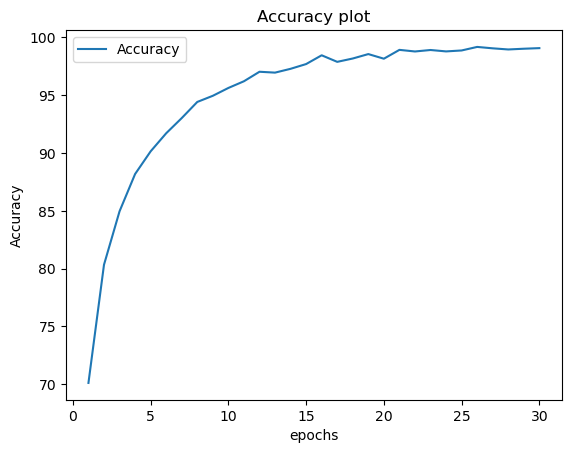

In [26]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

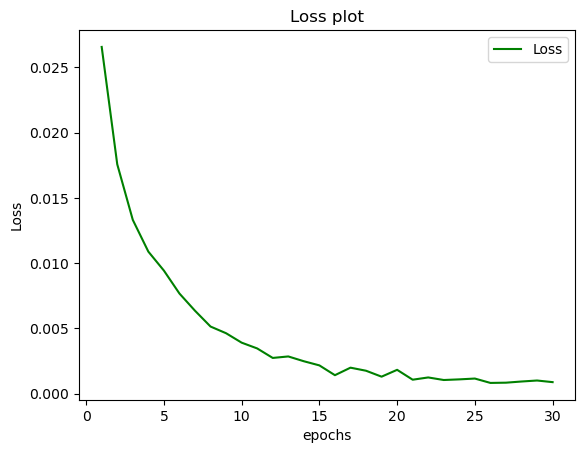

In [27]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])